In [7]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow

tfd = tfp.distributions

In [2]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [3]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [6]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.12751201
5.1175065


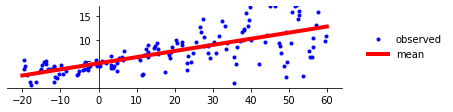

In [8]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [9]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.12273033 0.9403905 ]
[5.1976857 3.9606447]


In [18]:
yhat.variance()[-1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([9.411942], dtype=float32)>

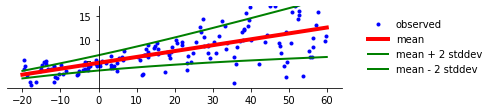

In [10]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [31]:

# Build model.
mix = 0.3






# lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))

model = tf.keras.Sequential(
	[
		tf.keras.layers.Dense(4),
		tfp.layers.DistributionLambda(
			lambda t: tfd.Mixture(
				cat=tfd.Categorical(probs=[mix, 1. - mix]),
				components=[
					tfd.Normal(loc=t[..., :1], scale= tf.math.softplus(0.05 * t[...,1:])),
					tfd.Normal(loc=t[..., :1], scale= tf.math.softplus(0.05 * t[...,1:]))
				]
			)
		)
	]
)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

ValueError: in user code:

    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 245, in __call__
        distribution, _ = super(DistributionLambda, self).__call__(
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 251, in call
        distribution, value = super(DistributionLambda, self).call(
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 172, in _fn
        d = make_distribution_fn(*fargs, **fkwargs)
    File "/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_39135/4292162716.py", line 15, in <lambda>
        lambda t: tfd.Mixture(
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/decorator.py", line 232, in fun
        return caller(func, *(extras + args), **kw)
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/distribution.py", line 298, in wrapped_init
        default_init(self_, *args, **kwargs)
    File "/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/tensorflow_probability/python/distributions/mixture.py", line 163, in __init__
        raise ValueError(

    ValueError: Exception encountered when calling layer "distribution_lambda_7" "                 f"(type DistributionLambda).
    
    components[0] batch shape must be compatible with cat shape and other component batch shapes (() vs (None, 3))
    
    Call arguments received by layer "distribution_lambda_7" "                 f"(type DistributionLambda):
      • inputs=tf.Tensor(shape=(None, 4), dtype=float32)
      • args=<class 'inspect._empty'>
      • kwargs={'training': 'True'}


In [28]:
yhat = model.predict(y)

63/63 [==============================] - 0s 461us/step


In [32]:
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')

    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [34]:
tf.float32

tf.float32

In [41]:
y, x, _ = load_dataset()

# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

# Build model.
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, num=num_inducing_points,
                        dtype=float)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(float))),
    ),
])

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, float) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_39135/1572852065.py:6: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._amplitude = self.add_variable(
/var/folders/bf/ytfysjqx15v252xy049gw1qm0000gn/T/ipykernel_39135/1572852065.py:11: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._length_scale = self.add_variable(


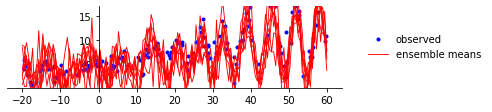

In [42]:
y, x, _ = load_dataset()

plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

num_samples = 7
for i in range(num_samples):
  sample_ = yhat.sample().numpy()
  plt.plot(x_tst,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))